In [161]:
import pandas as pd
import numpy as np
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
from mesa.space import MultiGrid
from mesa.visualization.UserParam import UserSettableParameter                                    
import scipy.stats as ss
import random
import matplotlib.pyplot as plt
import copy
import math
import itertools
from collections import defaultdict

import os

In [162]:
# utility functions

def generate_from_normal(mean, sd, size, low=0, upp=1):
  # TODO: change distribution?
#     print((low - mean), (upp - mean), mean, sd)
    if sd == 0:
#         print(sd, mean)
        sd = 0.001
#     return ss.truncnorm.rvs(
#         (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd, size=size)
    out = np.random.normal(mean, sd, size)
    return [fix_range(a, low, upp) for a in out]

def fix_range(num, low=0, high=1):
    if num < low:
        return low
    if num > high:
        return high
    return num

# create folder if it does not exist to save images

def init_folders():
    cwd = os.getcwd()
    paths = ['\images','\data']

    for path in paths:
        folder_path = cwd + path
        exists = os.path.exists(folder_path)
        if not exists:
            os.mkdir(folder_path)
            
            

def merge_dicts(d1, d2):
    for key, value in d2.items():
        d1[key].extend(value)
    return d1
            
init_folders()

In [213]:
# global constant for posts
# TODO: find justification for these values or change values
INFO_STALENESS_RATE = 0.8
POST_TRUTH_IMPACT = 0.2
POST_BELIEF_IMPACT = 0.2

LIKE_THRESHOLD = 0.5

POSTS = {}
# All the new created posts are in new_posts which will be emptied each step
POST_SIZE = 300

NEW_POSTS = {}
# Popular posts gets saved, population will be used to determine size of this posts.... it will have max capacity and unused ones will be removed
TOP_POSTS = {}
# Posts will be sum of these three dict
HOT_POSTS = {}


class Post:
    id_iter = itertools.count()
    
    def __init__(self, timestamp, creator, belief, veracity, novelty, sentiment, parent=None, views=0, children=[], likes=0, viewers=[]):
        self.id = next(self.id_iter)
        self.timestamp = timestamp
        self.creator = creator
        self.belief = belief
        self.veracity = veracity
        self.parent = parent
        self.novelty = novelty
        self.sentiment = sentiment
        self.views = views
        self.children = children
        self.likes = likes
        self.viewers = viewers
        self.liked_users = []
        self.hot_score = 0
        self.score = 0
        
        
    def __lt__(self, other):
        return self.score < other.score
    
    def __str__(self):
        return "likes-" + str(self.likes)
    
    def __repr__(self):
        return "likes-" + str(self.likes)
    
    def add_to_list(self, position):
        key = str(position[0])+"+"+str(position[1])
        if key in POSTS:
            NEW_POSTS[key].append(self)
        else:
            raise KeyError("Position does not exist")
    
    def increment_like(self, id):
        self.likes += 1
        self.liked_users.append(id)
        

    # shift bits to divide by 8, so new posts have more score to calculate top
    def score_post(self):
        self.score = math.floor(self.likes)
        return self.score


    # shift bits to divide by 8, so new posts have more score to calculate hotness
    def score_hot(self):
        old_score = self.hot_score
        score = self.hot_score>>3 + math.floor(self.likes<2+self.views>>3)-old_score
        self.hot_score = score
        return self.hot_score


def filter_new_posts():
    global NEW_POSTS
    keys = POSTS.keys()
    for key in keys:
        random.shuffle(NEW_POSTS[key])
        NEW_POSTS[key] = NEW_POSTS[key][:POST_SIZE]


# randomly choose top some posts and sort them into hot and top post and remove unwanted posts
def update_posts():
    filter_new_posts()
    get_scored_posts()
    keys = POSTS.keys()
    for key in keys:
        size = len(TOP_POSTS[key])
        if size>POST_SIZE:
            TOP_POSTS[key] = TOP_POSTS[key][:POST_SIZE]
        size = len(HOT_POSTS[key])
        if size>POST_SIZE:
            HOT_POSTS[key] = HOT_POSTS[key][:POST_SIZE]
            
        
    
    
def get_scored_posts():
    global NEW_POSTS
    global HOT_POSTS
    global TOP_POSTS
    keys = POSTS.keys()
    ## sort new posts
    TOP_POSTS = merge_dicts(TOP_POSTS, NEW_POSTS)
    HOT_POSTS = merge_dicts(HOT_POSTS, NEW_POSTS)
    
    for key in keys:
        TOP_POSTS[key] = sorted(TOP_POSTS[key], key=lambda x: x.score_post(), reverse=True)
        HOT_POSTS[key] = sorted(HOT_POSTS[key], key=lambda x: x.score_hot(), reverse=True)

In [206]:
class Agent(Agent):    
    def __init__(self, unique_id, model):
      # TODO: find justification for values or change values
        super().__init__(unique_id, model)
        self.agreeableness = 0
        # Emotions: real number from 0 to 1 for each - evolve over time
        # Anxious, Bored/neutral, Happy/excited, Confused, Scared, Angry/frustrated
        self.emotions = [0,0,0,0,0,0]
        # Beliefs - real number from 1 to 5 - evolve over time
        self.belief = 1
        # Activity Level
        # Frequency of posts and post creation per unit time - Real number
        # Time spent in social network per unit of time - Integer - # no of post user sees
        self.activity_level = [1,1]
        # Exposure to false news (measured from all posts interacted with) in unit time
        self.false_exposure = 0
        # Exploration: tendency to join new networks - real number from 0 to 1
        self.exploration = 0
        # Stability: tendency to leave a networks - real number from 0 to 1
        self.stablility = 0
        self.position = None
        self.posts_seen = []
        self.posts_liked = []
        
        
    def move(self):
      # TODO: implement
#         possible_steps = self.model.grid.get_neighborhood(
#             self.pos, moore=True, include_center=False
#         )
#         new_position = self.random.choice(possible_steps)
#         self.model.grid.move_agent(self, new_position)
        pass
   
    def create_new_post(self):
      # TODO: find justifications for values or change values
        post_belief = self.belief + random.uniform(-1, 1)
        post_belief = fix_range(post_belief, 1, 5)
        post_veracity = np.random.normal(self.false_exposure, 0.3, 1)[0]
        post_veracity = fix_range(post_veracity)
        post_novelty = np.random.normal(0.25, 0.3, 1)[0]
        post_novelty = fix_range(post_novelty)
        post_sentiment = np.random.normal(3, 2, 1)[0]
        post_sentiment = fix_range(post_sentiment, 1, 5)
        
        new_post = Post(self.model.current_step, self.unique_id, post_belief, post_veracity, post_novelty, post_sentiment, None)
        new_post.add_to_list(self.position)
        
    
    def view_post(self, key, idx, post_item, choice):
        # ignore post created by self
        post = None
        if choice == 1:
            post = TOP_POSTS[key][idx]
        elif choice == 2:
            post = HOT_POSTS[key][idx]
        elif choice == 3:
            post = NEW_POSTS[key][idx]
        if post.creator == self.unique_id:
            return
        
        post.views += 1
        # impact factor, new posts has greater impact
        # TODO: change this to give newer posts more impact?
        strength = 1
        novel_info = post.novelty
        seen_bool = False
        
        if self.unique_id in post.viewers:
            strength = 0.2 # TODO: justify this?
            novel_info = 0
        else:
            """ CHECK THIS CODE"""
            post.viewers.append(self.unique_id)
            
        # novelty of post can change depending on its age
        age = self.model.current_step - post.timestamp
        for i in range(age):
            if random.choice([0, 1]):
                novel_info = novel_info*INFO_STALENESS_RATE
        # compare belief
        belief_diff = post.belief - self.belief
        
        # post excitement - how extreme the post is
        # TODO: incorporate beliefs
        post_excitement = abs((3- abs(post.sentiment))/2)
        
        # update emotions
        self.update_post_emotion(post)
        
        self.false_exposure += (1-post.veracity) * POST_TRUTH_IMPACT * novel_info
        self.false_exposure = fix_range(self.false_exposure, 0, 1)
        
        self.belief += belief_diff * POST_BELIEF_IMPACT * novel_info
        self.belief = fix_range(self.belief, 1, 5)
        
        # likes the post
        # sentiment to determine boring
        agent_likes = (1 - abs(belief_diff)/5) * novel_info * post_excitement
        if self.unique_id not in post.liked_users:
            agent_likes = (1 - abs(belief_diff)/5) * post_excitement
            if agent_likes > LIKE_THRESHOLD:
                post.increment_like(self.unique_id)
        # impact emotion
        
        
    # update emotions based on post
    def update_post_emotion(self, post):
      # TODO: implement
        pass
    
    
    # function to relfect if user value matches group values or not, if not user leaves
    def relate_to_group():
      # TODO: implement
        pass
    
    
    # update attribute based on how much user spends time in network
    def update_attributes(self):
        time_spent = generate_from_normal(self.activity_level[1], self.activity_level[1]+3, 1, 0, 1000)[0]
        # visits social media
        time_spent = int(math.floor(time_spent))
        key = str(self.position[0])+"+"+str(self.position[1])
        all_posts = {}
        choice = 3
        if self.model.current_step < 2:
            all_posts = copy.deepcopy(NEW_POSTS[key])
            choice = 3
        else:
            temp = random.choices([(TOP_POSTS[key], 1), (HOT_POSTS[key], 2), (NEW_POSTS[key], 3)], [50, 30, 20], k=1)[0]
            all_posts = copy.deepcopy(temp[0])
            choice = temp[1]
        view_posts = all_posts[:time_spent]
        for idx, post in enumerate(view_posts):
            self.view_post(key, idx, post, choice)
        self.move()
        
    
    
    def step(self):
        num_posts = generate_from_normal(self.activity_level[0], self.activity_level[0]+3, 1, 0, 1000)[0]
        # make a post
        num_posts = int(math.floor(num_posts))
        for i in range(num_posts):
            self.create_new_post()
        self.update_attributes();
        self.move()
        

In [207]:
class SocialModel(Model):
    def __init__(self, num_agents, width, height, agreeableness, emotions, beliefs, activity, news, exploration, stability):
        self.num_agents = num_agents
        self.width = width
        self.height = height
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.agreeableness = agreeableness
        
        self.emotions = emotions
        self.beliefs = beliefs
        self.activity = activity
        self.news = news
        self.exploration = exploration
        self.stability = stability
        self.current_step = 0
        
        # random start
        for i in range(self.num_agents):
            a = Agent(i, self)
            self.schedule.add(a)

            # Add the agent to a random grid cell
            x = self.random.randrange(self.grid.width)
            y = self.random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))
            a.position = (x, y)
            # Random 
        
            
        self.datacollector = DataCollector(
            model_reporters={"belief": mean_belief, "total posts": num_posts, "total likes": num_likes}
        )
        
        init_population(self)
        init_posts(self)

        
    def step(self):
#         remove_unpopular_posts();
        self.current_step += 1
        self.datacollector.collect(self)
        self.schedule.step()
        update_posts()


        
# initialize conditions
            
def init_posts(model):
    global POSTS
    global NEW_POSTS
    global HOT_POSTS
    global TOP_POSTS
    POSTS = {}
    width = model.width
    height = model.height
    for w in range(width):
        for h in range(height):
            key = str(w)+"+"+str(h)
            POSTS[key] = []
            NEW_POSTS[key] = []
            HOT_POSTS[key] = []
            TOP_POSTS[key] = []
            
            
def init_population(model):
    total_population = model.num_agents
    agreeableness_list = generate_from_normal(model.agreeableness[0], model.agreeableness[1], total_population)
    # emotions
    anxious_list = generate_from_normal(model.emotions[0][0], model.emotions[0][1], total_population)
    bored_list = generate_from_normal(model.emotions[1][0], model.emotions[1][1], total_population)
    happy_list = generate_from_normal(model.emotions[2][0], model.emotions[2][1], total_population)
    confused_list = generate_from_normal(model.emotions[3][0], model.emotions[3][1], total_population)
    scared_list = generate_from_normal(model.emotions[4][0], model.emotions[4][1], total_population)
    angry_list = generate_from_normal(model.emotions[5][0], model.emotions[5][1], total_population)
    # beliefs
    beliefs_list = generate_from_normal(model.beliefs[0], model.beliefs[1], total_population, 1, 5)
    # beliefs
    act_post_list = generate_from_normal(model.activity[0][0], model.activity[0][1], total_population, 0, 100000)
    act_time_list = generate_from_normal(model.activity[1][0], model.activity[1][1], total_population,  0, 100000)
    # false news
    false_news_list = generate_from_normal(model.news[0], model.news[1], total_population)
    # exploration
    exploration_list = generate_from_normal(model.exploration[0], model.exploration[1], total_population)
    # stability
    stability_list = generate_from_normal(model.stability[0], model.stability[1], total_population)
    
    for idx, a in enumerate(model.schedule.agents):
        a.agreeableness = agreeableness_list[idx]
        a.emotions = [anxious_list[idx], bored_list[idx], happy_list[idx], confused_list[idx], scared_list[idx], angry_list[idx]]
        a.belief = beliefs_list[idx]
        a.activity_level = [math.floor(act_post_list[idx]), math.floor(act_time_list[idx])]
        a.false_exposure = false_news_list[idx]
        a.exploration = exploration_list[idx]
        a.stablility = stability_list[idx]


def mean_belief(model):
    total_beliefs = [agent.belief for agent in model.schedule.agents]
    N = model.num_agents
    B = float(sum(total_beliefs))
    return B/N

def num_posts(model):
    posts_count = [len(item) for item in TOP_POSTS.values()]
    return sum(posts_count)


def num_likes(model):
    posts_count = [item for item in TOP_POSTS.values()]
    likes_count = 0
    for posts in posts_count:
        test = sum([post.likes for post in posts])
        likes_count += test
    return likes_count

In [211]:
# default settings

# num_agents, width, height, agreeableness, emotions, beliefs, activity, news, exploration, stability
def reset_default():
    global NUM_STEP
    
    global POPULATION
    global WIDTH
    global HEIGHT
    
    global AGREEABLENESS
    
    global ANXIOUS
    global BORED
    global HAPPY
    global CONFUSED
    global SCARED
    global ANGRY
    
    global BELIEFS
    
    global ACT_POSTS
    global ACT_TIME
    
    global FALSE_EXPOSURE
    
    global EXPLORATION
    global STABILITY
    
    global EMOTIONS
    global ACTIVITY_LEVEL
    
    NUM_STEP = 100
    
    POPULATION = 100
#     POPULATION = 10
    WIDTH = 5
    HEIGHT = 5
#     WIDTH = 3
#     HEIGHT = 2
    
    # mean and variance
    AGREEABLENESS = [0.5, 0.4]
    
    ANXIOUS = [0.5, 0.4]
    BORED = [0.5, 0.4]
    HAPPY = [0.5, 0.4]
    CONFUSED = [0.5, 0.4]
    SCARED = [0.5, 0.4]
    ANGRY = [0.5, 0.4]
    
    EMOTIONS = [ANXIOUS, BORED, HAPPY, CONFUSED, SCARED, ANGRY]
    
    BELIEFS = [3, 2]
    
    ACT_POSTS = [0.3, 0.3]
    ACT_TIME = [10, 20]
    
    ACTIVITY_LEVEL = [ACT_POSTS, ACT_TIME]
    
    FALSE_EXPOSURE = [0.3, 0.2]
    
    EXPLORATION = [0.5, 0.4]
    STABILITY = [0.5, 0.4]

     belief  total posts  total likes
0  3.251159            0            0
1  3.251159          106           39
2  3.250777          294          183
3  3.256878          577          380
4  3.257591          952          736
--- 20.95703673362732 seconds ---


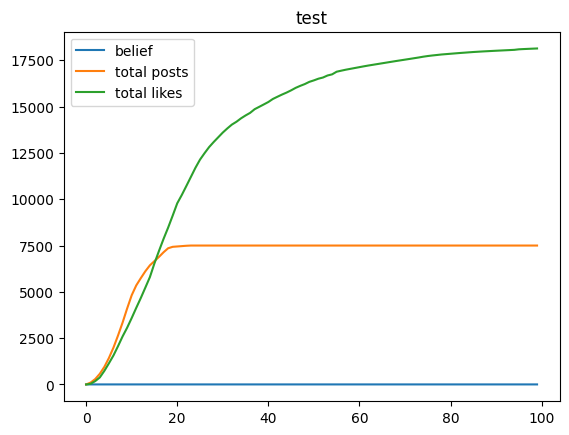

<Figure size 640x480 with 0 Axes>

In [212]:
# Default Model Run
import time

start_time = time.time()
reset_default()
    
model = SocialModel(POPULATION, WIDTH, HEIGHT, AGREEABLENESS, EMOTIONS, BELIEFS, ACTIVITY_LEVEL, FALSE_EXPOSURE, EXPLORATION, STABILITY)
for i in range(NUM_STEP):
    model.step()
#     for key in POSTS.keys():
#         print(len(POSTS[key]))
df = model.datacollector.get_model_vars_dataframe()
print(df.head())
title = "test"
#     covid_df.to_csv("data/"+title+".csv", index=False)
plot = df.plot(title=title)
fig = plt.figure()
fig = plot.get_figure()
print("--- %s seconds ---" % (time.time() - start_time))
# fig.savefig("images/" + title+".png")

In [210]:
keys = TOP_POSTS.keys()
# for key in keys:
#     TOP_POSTS[key][0].likes
#     TOP_POSTS[key][1].likes
for key in keys:
    print(key)
    print(TOP_POSTS[key])

0+0
[likes-8, likes-8, likes-8, likes-8, likes-8, likes-8, likes-8, likes-8, likes-8, likes-8, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-6, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-5, likes-3, likes-3, likes-3, likes-2, likes-2, likes-1, likes-1, likes-1, likes-1, likes-1, likes-1, likes-1, likes-1, likes-1, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes-0, likes

In [131]:
print(TOP_POSTS["0+0"][0])

likes-2
